This notebook is run on Google Colab due to limitations in GPU. To run this in your local computer, please the format of reading into:

 manhattan = pd.read_csv("../data/curated/manhattan_time_series.csv")


 queens = pd.read_csv("../data/curated/queens_time_series.csv")



 Please note that different runs can yield different results although a random seed has been set.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
import os


from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras

from keras import optimizers
from keras.layers import Dense, Dropout,LSTM


In [2]:
import pandas as pd

In [10]:
WINDOW = 4
HORIZON = 1
# to produce the results in the report, pleasze change the WINDOW and
# HORIZON

# This means that we are currently based on the previous 4 days - 96 hours to
# predict the next 1 hour

n_steps = 24 * WINDOW
n_features = HORIZON
scaler = StandardScaler()


def fillna(df):
  return df.fillna(method = 'ffill')


def fillna_interpolation(df):
  """
  Fill na for every single feature in df by linear interpolcation
  Different methods have been used yet linear the best
  """

  new_df = df.copy()
  for feature_var in new_df:
    series = new_df[feature_var]
    series = series.interpolate(method = 'linear')
    # series = series.interpolate(method = 'spline', order = 2)
    # series = series.interpolate(method = 'polynomial', order = 3)

    new_df.loc[:, feature_var] = series
  return new_df




def cleaning_X(df):
  """
  remove unnecessary cols
  """
  return df.drop(["rounded_pickup"], axis = 1)

def normalize_scaler(df, training= None):
  """
  normalize the dataset by StandardScaling, depending on training or not
  to first fit the scaler then transform
  """
  if training:
    return scaler.fit_transform(df)
  else:
    return scaler.transform(df)

def normalize(train_df):
  """
  This is the older version of the previous one. This is no longer used
  """
  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  return train_df

# def categorical_process(df_clean):
#   cat_attribs = ['wd']
#   full_pipeline = ColumnTransformer([
#     ("cat", OneHotEncoder(categories='auto', handle_unknown= 'ignore'),
#       cat_attribs)
#   ], remainder = 'passthrough')
#   df_prepared = full_pipeline.fit_transform(df_clean)
#   return df_prepared

def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    Denoises data using the fast fourier transform. Yet this is not used in code
    References
    ----------
    [1] Steve Brunton - Denoising Data with FFT[Python]

    """
    n = len(x)

    # compute the fft
    fft = np.fft.fft(x, n)

    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n

    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft

    # inverse fourier transform
    clean_data = np.fft.ifft(fft)

    if to_real:
        clean_data = clean_data.real

    return clean_data

def denoise_data(df):
  """
  smooth out the data when the data has so many fluctuations. This is used
  as a tool to average the numbers in a defined period, yet not used in this
  case
  """
  ROLLING = 15
  df_copy = df.copy()
  for feature_var in df_copy:
    series = df_copy[feature_var]
    # rolling to get the average
    series = series.rolling(ROLLING).mean().dropna(axis = 0, how = 'all')
    series = series.to_numpy()
    # series = fft_denoiser(series, 0.95)
    # replace
    df_copy.loc[ROLLING - 1: , feature_var] = series

  return df_copy



def preprocessing_data(df):
  """
  This function is the preprocessing data, which is the older version,
  refer to the new version below
  """
  df_clean = cleaning_X(df.copy())
  df_clean = fillna_interpolation(df_clean)
  # y = df_clean['count']
  # print(df_clean.shape)

  num_attribs = list(df_clean.columns)[:]
  df_clean = normalize(df_clean[num_attribs])
  # df_clean['count'] = y
  # df_clean = denoise_data(df_clean)


  # print(df_clean)

  # df_clean = categorical_process(final_df_clean.copy())

  return df_clean

def preprocessing_data_scaler(df, training):
  """
  This function preprocesses the dataset witl standard scaling.
  It goes through a series of processes including imputation and standard
  scaling
  """
  df_clean = cleaning_X(df.copy())
#   linear interpolation
  df_clean = fillna_interpolation(df_clean)
  # y = df_clean['count']
  # print(df_clean.shape)

  num_attribs = list(df_clean.columns)[:]
  print(num_attribs)
#   normalize using stdscaling
  df_clean = normalize_scaler(df_clean[num_attribs], training)
  # df_clean['count'] = y
  # df_clean = denoise_data(df_clean)


  # print(df_clean)

  # df_clean = categorical_process(final_df_clean.copy())

  return df_clean


def split_sequence(sequence, n_steps, return_x = True):
    """
    This function is used to conduct window slicing method,
     a highly popular method in handling time series dataset.
    """
    X, y = list(), list()
    # iterate over the sequence
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1 - n_features:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = \
            sequence[i:end_ix, :], sequence[end_ix: end_ix + n_features, 0:1]
        X.append(seq_x)
        y.append(seq_y)
    # print(len(X), len(y))
    if return_x:
        # return features and labels
      return np.array(X), np.array(y).reshape(-1,n_features)


def split_y_sequence(sequence, n_steps):
  """
  This is the depriciated version of the previous one. Please ignore this one
  """
  y = list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence) - 1 -n_features:
      break
    seq_y = sequence[end_ix : end_ix + n_features]
    y.append(seq_y)

  return np.array(y).reshape(-1, HORIZON)

In [11]:
# if you run on colab, upload these 2 files in your session and just run
manhattan = pd.read_csv("./manhattan_time_series.csv")
queens = pd.read_csv("./queens_time_series.csv")

# please change to this if you are running on your computer:
# manhattan = pd.read_csv("../data/curated/manhattan_time_series.csv")
# queens = pd.read_csv("../data/curated/queens_time_series.csv")

In [12]:
def partition_train_test_valid(df):
    """
    Partiotion the dataste closest to 70-15-15, specify the range to be divided
    """
    x_train = df[df['rounded_pickup'] < "2022-11-01"]
    x_valid = df[(df['rounded_pickup'] >= "2022-11-01") \
        & (df['rounded_pickup'] < "2023-01-01")]
    x_test = df[(df['rounded_pickup'] >= "2022-11-01") \
        & (df['rounded_pickup'] < "2023-01-01")]
    print(x_train.shape, x_valid.shape, x_test.shape)
    return x_train, x_valid, x_test

train_m, valid_m, test_m = partition_train_test_valid(manhattan)
# train_q, valid_q, test_q = partition_train_test_valid(queens)

train_m.to_csv("./train_m.csv", header = True, index = False)
valid_m.to_csv("./valid_m.csv", header = True, index = False)
test_m.to_csv("./test_m.csv", header = True, index = False)


(6552, 5) (1464, 5) (1464, 5)


In [13]:
df = pd.read_csv("train_m.csv")
df_clean = preprocessing_data_scaler(df, training = True)

print(df_clean.shape)


df_valid = pd.read_csv("valid_m.csv")
df_valid_clean = preprocessing_data_scaler(df_valid, training = False)

print(df_valid_clean.shape)

df_test = pd.read_csv("test_m.csv")
df_test_clean = preprocessing_data_scaler(df_test, training = False)

# print(df_test_clean.shape)

# window slicing method
X, y = split_sequence(df_clean, n_steps)
print(X.shape, y.shape)

X_valid, y_valid = split_sequence(df_valid_clean, n_steps)
print(X_valid.shape, y_valid.shape)

X_test, y_test = split_sequence(df_test_clean, n_steps)
print(X_test.shape, y_test.shape)

['count', 'sum(ridership)', 'avg_tmp', 'avg_wind_speed']
(6552, 4)
['count', 'sum(ridership)', 'avg_tmp', 'avg_wind_speed']
(1464, 4)
['count', 'sum(ridership)', 'avg_tmp', 'avg_wind_speed']
(6455, 96, 4) (6455, 1)
(1367, 96, 4) (1367, 1)
(1367, 96, 4) (1367, 1)


In [14]:
# convert back to original data
y_test_real = y_test*np.sqrt(scaler.var_[0]) + scaler.mean_[0]
y_test_real

array([[5009.],
       [4210.],
       [3257.],
       ...,
       [5120.],
       [4796.],
       [3285.]])

In [15]:
# scaler.transform(np.array().reshape(-1,1))
# play
df['count'][48:52]

48    1545.0
49     762.0
50     386.0
51     261.0
Name: count, dtype: float64

In [16]:
# play
y*np.sqrt(scaler.var_[0]) + scaler.mean_[0]

array([[4468.],
       [3668.],
       [2789.],
       ...,
       [5167.],
       [3970.],
       [3104.]])

In [17]:
y_valid[0]*np.sqrt(scaler.var_[0]) + scaler.mean_[0]

array([5009.])

In [18]:
df_valid['count'][48:52]

48    2068.0
49    1066.0
50     563.0
51     356.0
Name: count, dtype: float64

# Training
Please ignore this part, this is just my playground

In [19]:


# class Time2Vector(keras.layers.Layer):
#     def __init__(self, seq_len, **kwargs):
#         super(Time2Vector, self).__init__(**kwargs)
#         self.seq_len = seq_len

#     def build(self, input_shape):
#         '''Initialize weights and biases with shape (batch, seq_len)'''
#         self.weights_linear = self.add_weight(name='weight_linear',
#                                     shape=(int(self.seq_len),),
#                                     initializer='uniform',
#                                     trainable=True)

#         self.bias_linear = self.add_weight(name='bias_linear',
#                                     shape=(int(self.seq_len),),
#                                     initializer='uniform',
#                                     trainable=True)

#         self.weights_periodic = self.add_weight(name='weight_periodic',
#                                     shape=(int(self.seq_len),),
#                                     initializer='uniform',
#                                     trainable=True)

#         self.bias_periodic = self.add_weight(name='bias_periodic',
#                                     shape=(int(self.seq_len),),
#                                     initializer='uniform',
#                                     trainable=True)

#     def call(self, x):
#         '''Calculate linear and periodic time features'''
#         x = tf.math.reduce_mean(x[:,:,:3], axis=-1)
#         time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
#         time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

#         time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
#         time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
#         return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)


#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "sequence_len": self.seq_len })
#         return config


# #################################
# # custom n-beat model
# ################################
# class n_beat_block(tf.keras.layers.Layer):
#     def __init__(self, n_neurons, n_layers, window, horizontal, **kwargs):
#         super().__init__(**kwargs)
#         self.n_neurons = n_neurons
#         self.n_layers = n_layers
#         self.window = window
#         self.horizontal = horizontal
#         theta_size = window + horizontal
#         self.hidden_layers = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
#         self.theta_layer = keras.layers.Dense(theta_size, activation = 'linear')

#     def call(self, inputs):
#         x = self.hidden_layers[0](inputs)
#         for layer in self.hidden_layers[1:]:
#             x = layer(x)
#         theta = self.theta_layer(x)
#         backcast, forecast = theta[:, :self.window], theta[:, -self.horizontal:]
#         return backcast, forecast

#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "n_neurons": self.n_neurons,
#             "n_layer": self.n_layers,
#             "window": self.window,
#             "horizontal": self.horizontal
#         })
#         return config


# class nbeat(tf.keras.layers.Layer):
#     def __init__(self, n_neurons, n_layers, window, horizontal, **kwargs):
#         super().__init__(**kwargs)
#         self.n_neurons = n_neurons
#         self.n_layers = n_layers
#         self.window = window
#         self.horizontal = horizontal
#         self.flatten = keras.layers.Flatten()
#         self.hidden = [keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]
#         self.theta = keras.layers.Dense(window + horizontal, activation = 'linear')

#     def call(self, inputs):
#         x = inputs
#         x = self.flatten(x)
#         for layer in self.hidden:
#             x = layer(x)
#         theta = self.theta(x)
#         #squeeze = keras.layers.Lambda(lambda x: tf.squeeze(x))(theta)
#         #backcast, forecast = squeeze[:, :window], squeeze[:, -horizontal:]
#         backcast, forecast = theta[: , :self.window], theta[:, -self.horizontal:]
#         return backcast, forecast


#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "n_neurons": self.n_neurons,
#             "n_layer": self.n_layers,
#             "window": self.window,
#             "horizontal": self.horizontal
#         })
#         return config



# def build_nbeat(window , horizontal, feature, n_block = 4, n_neurons = 64, n_layers = 2):
#     inputs = keras.layers.Input(shape = (window, feature))
#     time = Time2Vector(window)(inputs)
#     concat = keras.layers.Concatenate(axis = -1)([inputs, time])
#     nbeat_block = nbeat(n_neurons = n_neurons,
#                         n_layers = n_layers,
#                         window = window,
#                         horizontal = horizontal)
#     backcast, forecast = nbeat_block(concat)

#     for _ in range(n_block):

#         block_backcast, block_forecast = n_beat_block(n_neurons = n_neurons,
#                                                       n_layers = n_layers,
#                                                       window = window,
#                                                       horizontal = horizontal)(backcast)

#         forecast = keras.layers.add([forecast, block_forecast])
#         backcast = keras.layers.subtract([backcast, block_backcast])

#     model = keras.Model(inputs = inputs, outputs = forecast)
#     return model


# LSTM + GRU

In [28]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
tf.keras.utils.set_random_seed(
    42
)

from keras import optimizers
from keras.layers import Dense, Dropout,LSTM, LSTM, GRU, SimpleRNN

mae_metrics = []
mse_metrics = []

y_test_inv_lst = []

# RMSE in tensorflow
def root_mean_squared_error(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_mean(tf.math.square(y_true - y_pred)))

def recurrent_network(layer):
  """
  This functions build the architecture as specified in the report with an
  input from the user specifying the component, either GRU or LSTM.

  This function will start the training process, printing out the evaluation
  metrics, while returning predicted values for test set at the end and the
  histroy for validation and training plot
  """

    # building architecture
  model = Sequential()
  model.add(tf.keras.layers.LayerNormalization())
  model.add(layer(units = 250, input_shape=(X.shape[1], X.shape[2]), \
    return_sequences = True))
  model.add(tf.keras.layers.LayerNormalization())
  model.add(tf.keras.layers.Dropout(rate = 0.25))
  model.add(layer(units = 150, input_shape=(X.shape[1], X.shape[2]), \
    return_sequences = True))
  model.add(tf.keras.layers.LayerNormalization())
  model.add(tf.keras.layers.Dropout(rate = 0.25))
  model.add(layer(units = 100, input_shape=(X.shape[1], X.shape[2])))
  model.add(tf.keras.layers.LayerNormalization())
  model.add(tf.keras.layers.Dropout(rate = 0.25))
  model.add(Dense(units = HORIZON))


# Optimizer
  model.compile(optimizer = 'adam', loss = 'mse', \
    metrics = [tf.keras.metrics.RootMeanSquaredError()])
  # model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

# Define the ModelCheckpoint callback with save_best_only=True and
  checkpoint_cb = keras.callbacks.ModelCheckpoint(
    f"air_train_{layer}.h5", save_best_only=True, monitor='val_loss', \
        mode='min', verbose=1)
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss', \
    patience = 3)

  hist = model.fit(X, y, validation_data = (X_valid, y_valid), epochs = 20, \
    verbose = 1,  callbacks = [checkpoint_cb, early_stopping_cb])

  train_mean = df[['count']].mean().to_numpy()
  train_std = df[['count']].std().to_numpy()


  # Prediction on test set
#   window slicing the test set
  X_test, y_test = split_sequence(df_test_clean, n_steps)

#   load best model
  recons_model = tf.keras.models.load_model(f"air_train_{layer}.h5")

  y_pred = recons_model.predict(X_test)

  print(y_pred.shape)

  y_test_real = y_test * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
  print(y_test_real.shape)

  y_pred_inverse = y_pred * np.sqrt(scaler.var_[0]) + scaler.mean_[0]



  print(f"RMSE: {root_mean_squared_error(y_test_real, y_pred_inverse).numpy()}")
  mae = tf.keras.losses.MeanAbsoluteError()
  print(f"MAE: {mae(y_test_real, y_pred_inverse).numpy()}")

  mae_metrics.append(mae(y_test_real, y_pred_inverse).numpy())
  mse_metrics.append(root_mean_squared_error(y_test_real, y_pred_inverse).numpy())

# model predictions
  y_test_inv_lst.append(y_pred_inverse)
  return hist



networks = [GRU, LSTM]
histories = []
for network in networks:
  print(network)
  hist = recurrent_network(network)
  histories.append(hist)



<class 'keras.layers.rnn.gru.GRU'>
Epoch 1/20
199/202 [============================>.] - ETA: 0s - loss: 1.0266 - root_mean_squared_error: 1.0132
Epoch 1: val_loss improved from inf to 0.40252, saving model to air_train_<class 'keras.layers.rnn.gru.GRU'>.h5
202/202 [==============================] - 13s 26ms/step - loss: 1.0220 - root_mean_squared_error: 1.0109 - val_loss: 0.4025 - val_root_mean_squared_error: 0.6344
Epoch 2/20
202/202 [==============================] - ETA: 0s - loss: 0.4561 - root_mean_squared_error: 0.6754
Epoch 2: val_loss improved from 0.40252 to 0.20702, saving model to air_train_<class 'keras.layers.rnn.gru.GRU'>.h5
202/202 [==============================] - 3s 17ms/step - loss: 0.4561 - root_mean_squared_error: 0.6754 - val_loss: 0.2070 - val_root_mean_squared_error: 0.4550
Epoch 3/20
202/202 [==============================] - ETA: 0s - loss: 0.2689 - root_mean_squared_error: 0.5185
Epoch 3: val_loss did not improve from 0.20702
202/202 [=======================

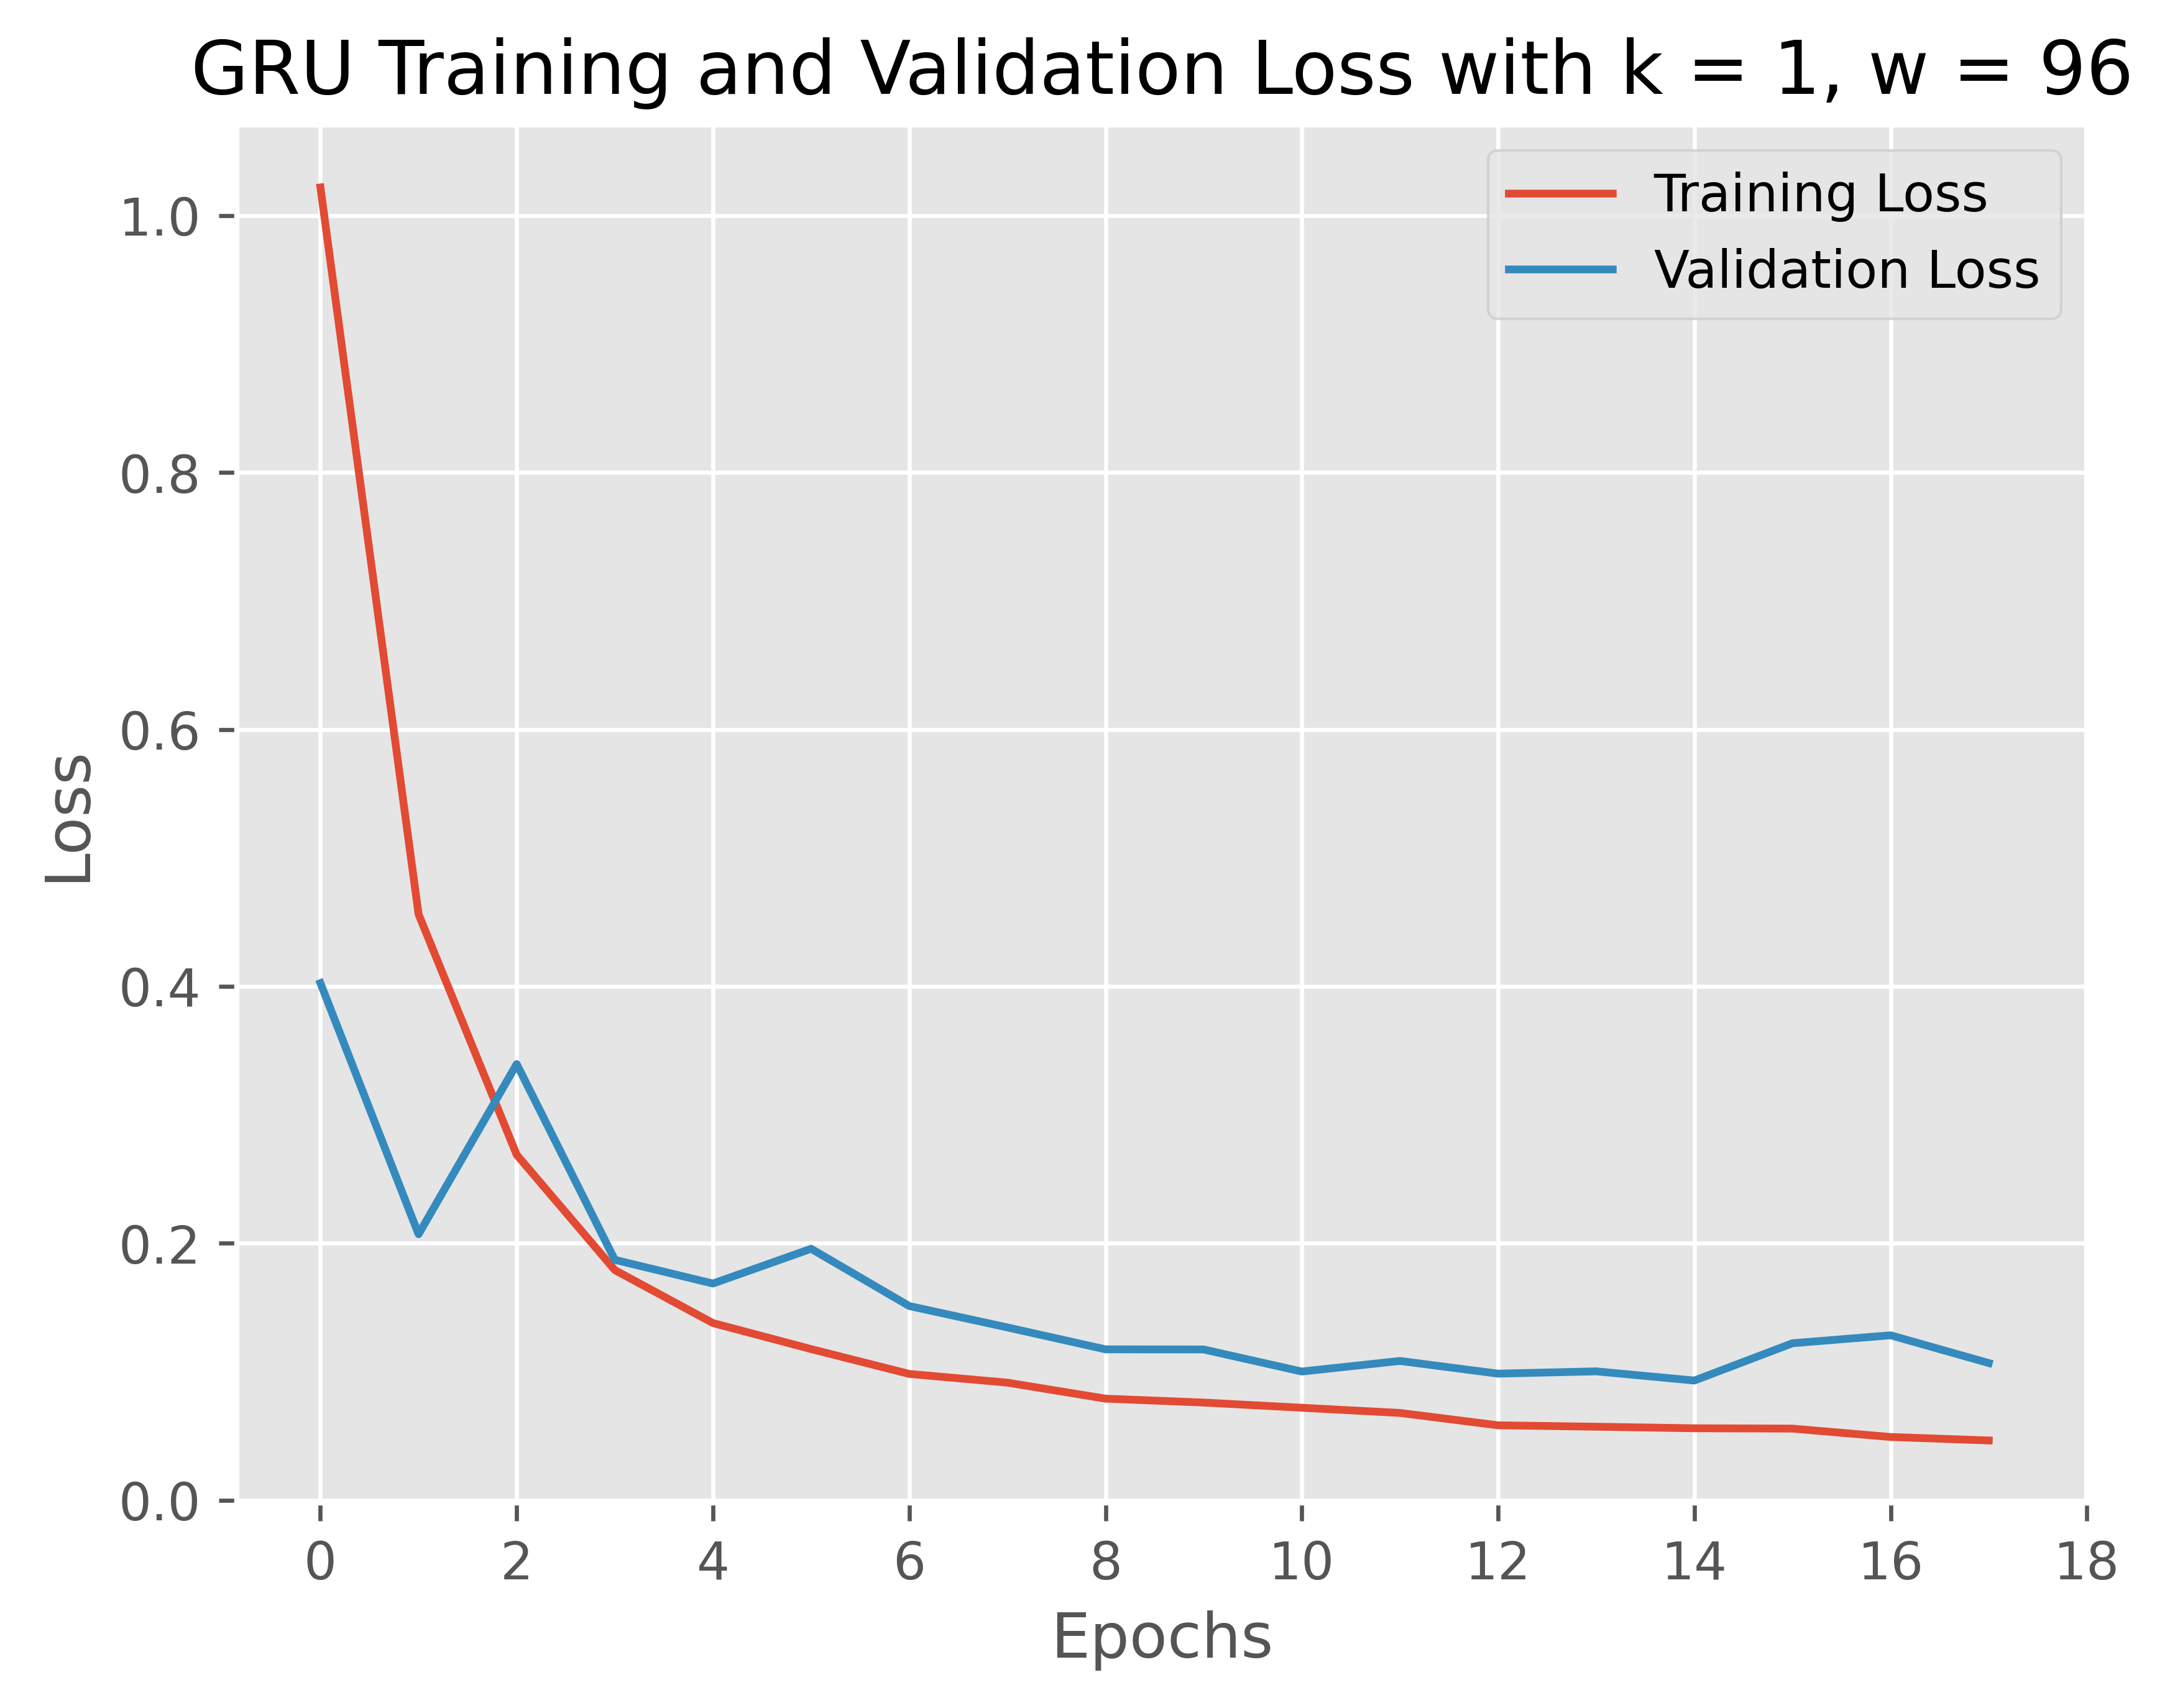

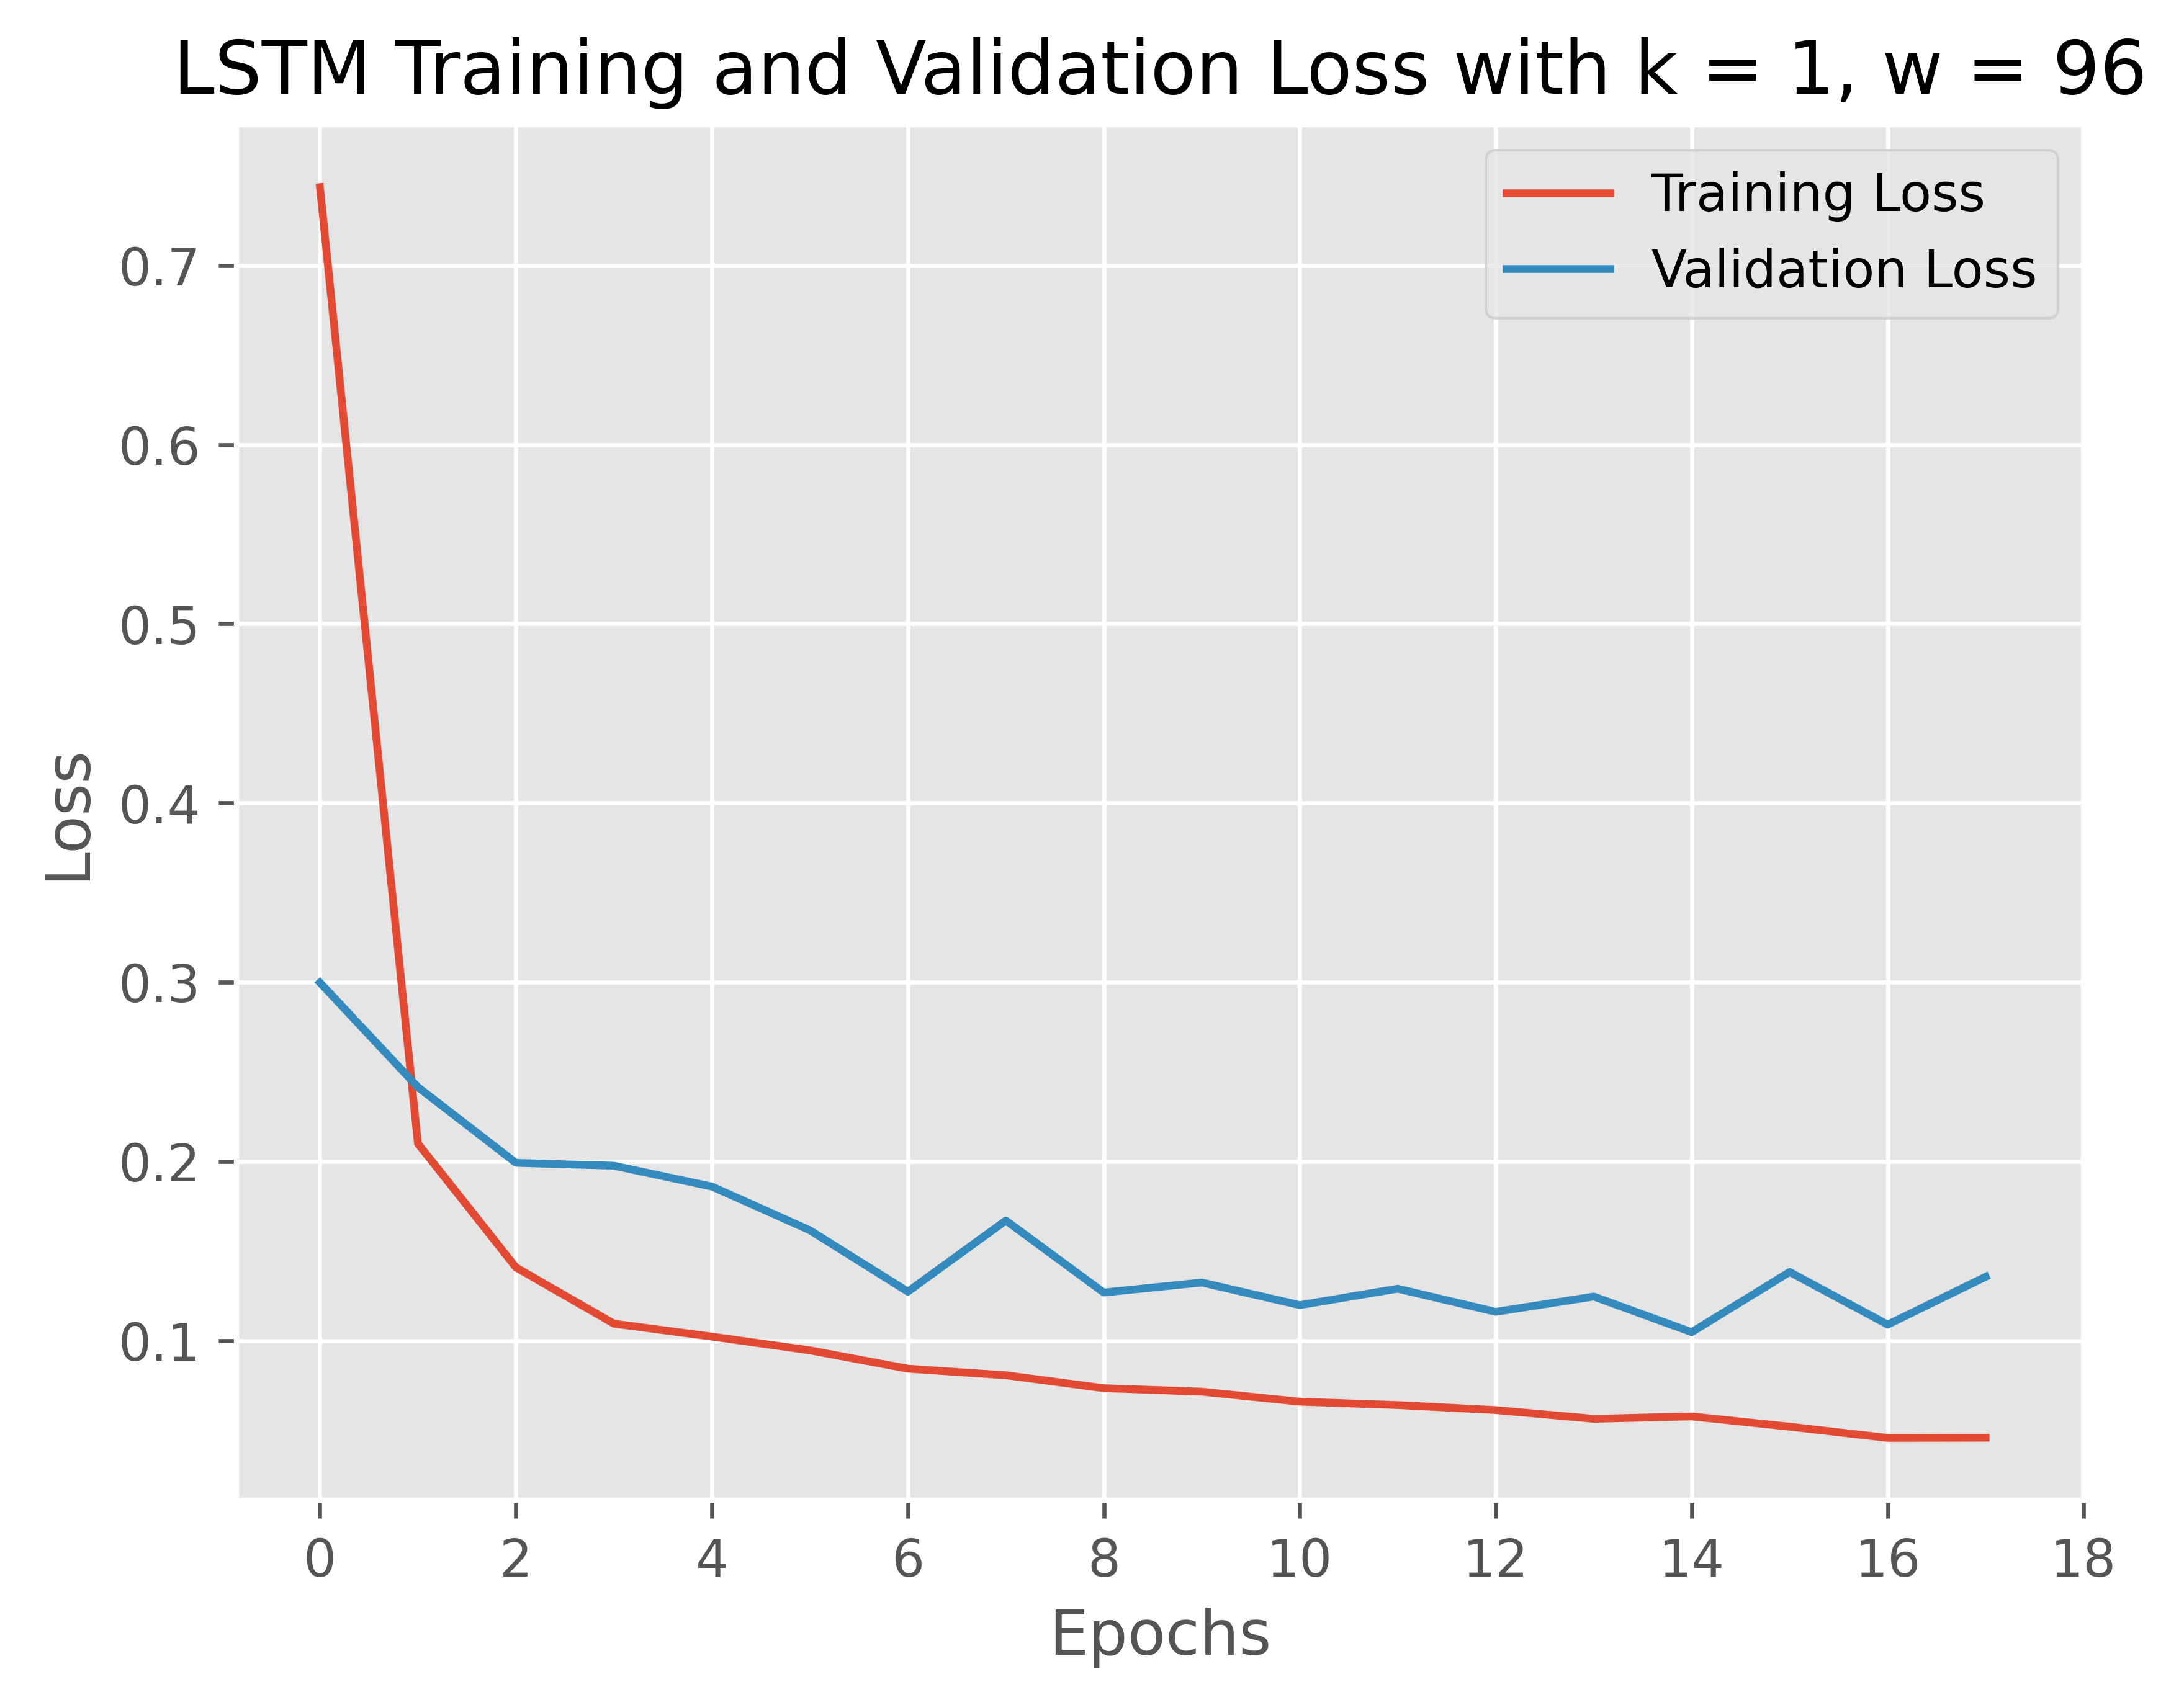

In [29]:
# Plot the training and validation loss curves
def plot_history(histories, ind):
  if ind == 0:
    title = "GRU"
  else:
    title = "LSTM"
  plt.figure(dpi = 600)
  plt.plot(histories[ind].history['loss'], label='Training Loss')
  plt.plot(histories[ind].history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'{title} Training and Validation Loss with k = 1, w = 96')
  plt.legend()
  plt.xticks(range(0,20,2))
  plt.savefig(f'{title}.png', bbox_inches='tight')
  plt.show()


plot_history(histories, 0)
plot_history(histories, 1)


In [24]:
y_test_real.shape

(1367, 1)

360 (360,)


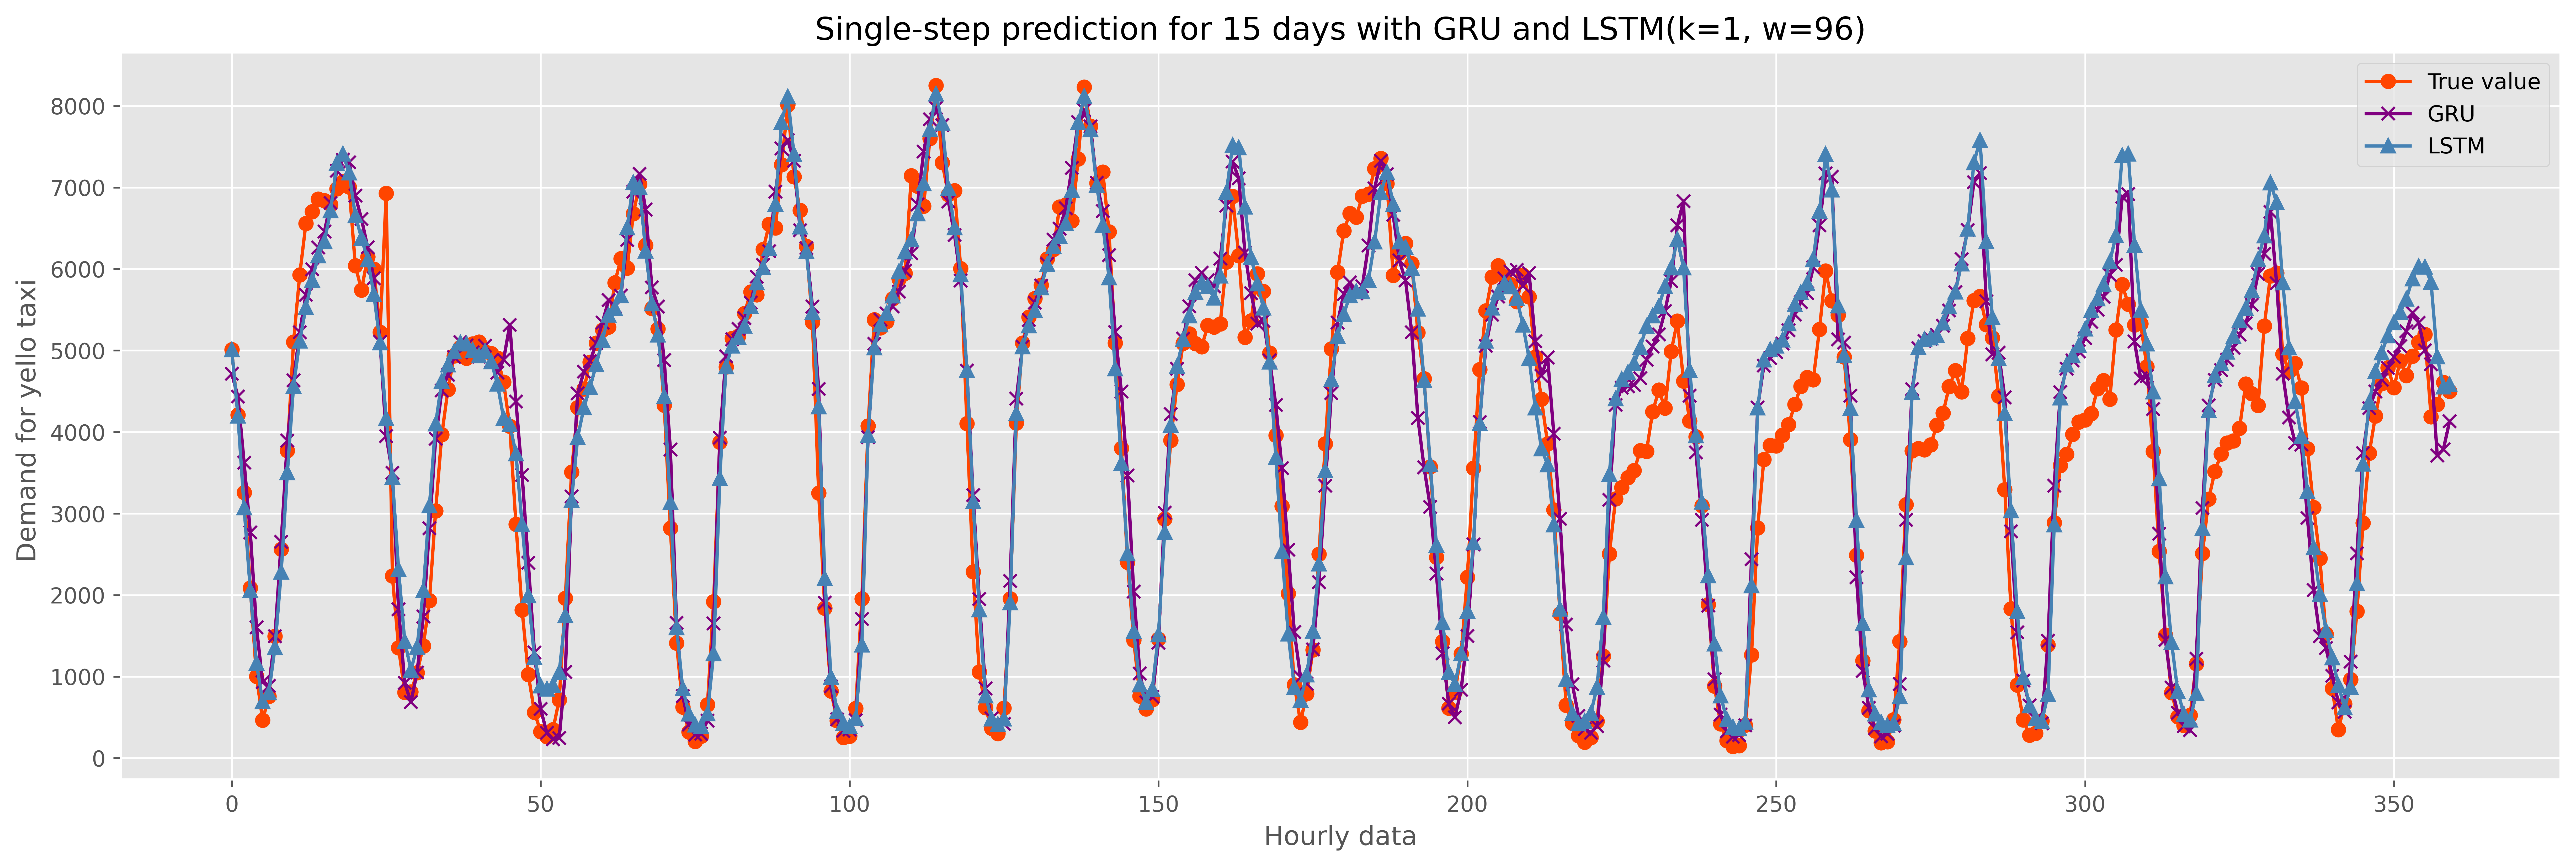

In [27]:
# how many steps in the test set output
future = 360

def plot_difference_better(y):
  """
  This fction outputs the plot of both GRU and LSTM on the same plot with
  4 days look back window and single step prediction. This will help
  visualize how models work and error analysis
  """
  plt.style.use('ggplot')
  plt.figure(figsize=(20, 6), dpi = 600) #, dpi = 800
  times = range(len(y))
  y_to_plot = y.flatten()
  print(len(times), y_to_plot.shape)
  plt.plot(times,y_to_plot, color='orangered',  marker = 'o',label='True value')

  for i in range(len(y_test_inv_lst)):
    if i == 0:
      plt.plot(times, y_test_inv_lst[i].flatten()[:future], \
         marker = 'x',color = 'purple', label = 'GRU')
    elif i == 1:
      plt.plot(times, y_test_inv_lst[i].flatten()[:future], \
        marker = '^', color = 'steelblue', label = 'LSTM')
    else:
      plt.plot(times, y_test_inv_lst[i].flatten()[:future], \
        marker = '^', color = 'purple', label = 'N-BEATS')


  # plt.ylim([-10, 355])
  # plt.xlim([-5, 310])
  plt.title('Single-step prediction for 15 days with GRU and LSTM(k=1, w=96)')
  plt.xlabel('Hourly data')
  plt.ylabel('Demand for yello taxi ')
  plt.legend()
  plt.savefig('better.png', bbox_inches='tight')
  plt.show()



plot_difference_better(y_test_real[:future])

array([[53.25363727],
       [54.60482009],
       [54.4300903 ],
       ...,
       [24.529983  ],
       [28.43858447],
       [33.21157988]])